In [1]:
# Comparison of training between to similar nets: one classical feedforward and one FGN
# here you can see that a similar FGN (same size per hidden units) can perform as well as classical feedforward network

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np

import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [5]:
!gpustat

crescent  Tue Jul  9 10:18:06 2019
[0] GeForce GTX 1080 | 53'C,   0 % |   569 /  8119 MB | felix(559M)
[1] GeForce GTX 1080 | 55'C,   0 % |  1502 /  8119 MB | felix(553M) felix(939M)


In [6]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device
torch.cuda.set_device(0)

CUDA Available:  True
Using device: cuda


In [7]:
# # random seeds
# torch.manual_seed(999)
# np.random.seed(999)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [8]:
# MNIST dataset and dataloader declaration
# transforms does both the conversion from 0-255 to 0-1
# and normalizes by the precomputed mean and std

batch_size = 192

mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../MNIST-dataset', train=True, download=False, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=batch_size, shuffle=True)

mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../MNIST-dataset', train=False, download=False, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=batch_size, shuffle=True)

Shape: torch.Size([60000, 28, 28])
type: <type 'numpy.ndarray'>
shape: torch.Size([28, 28])
Label: 5
type: <class 'torch.Tensor'>


<IPython.core.display.Javascript object>


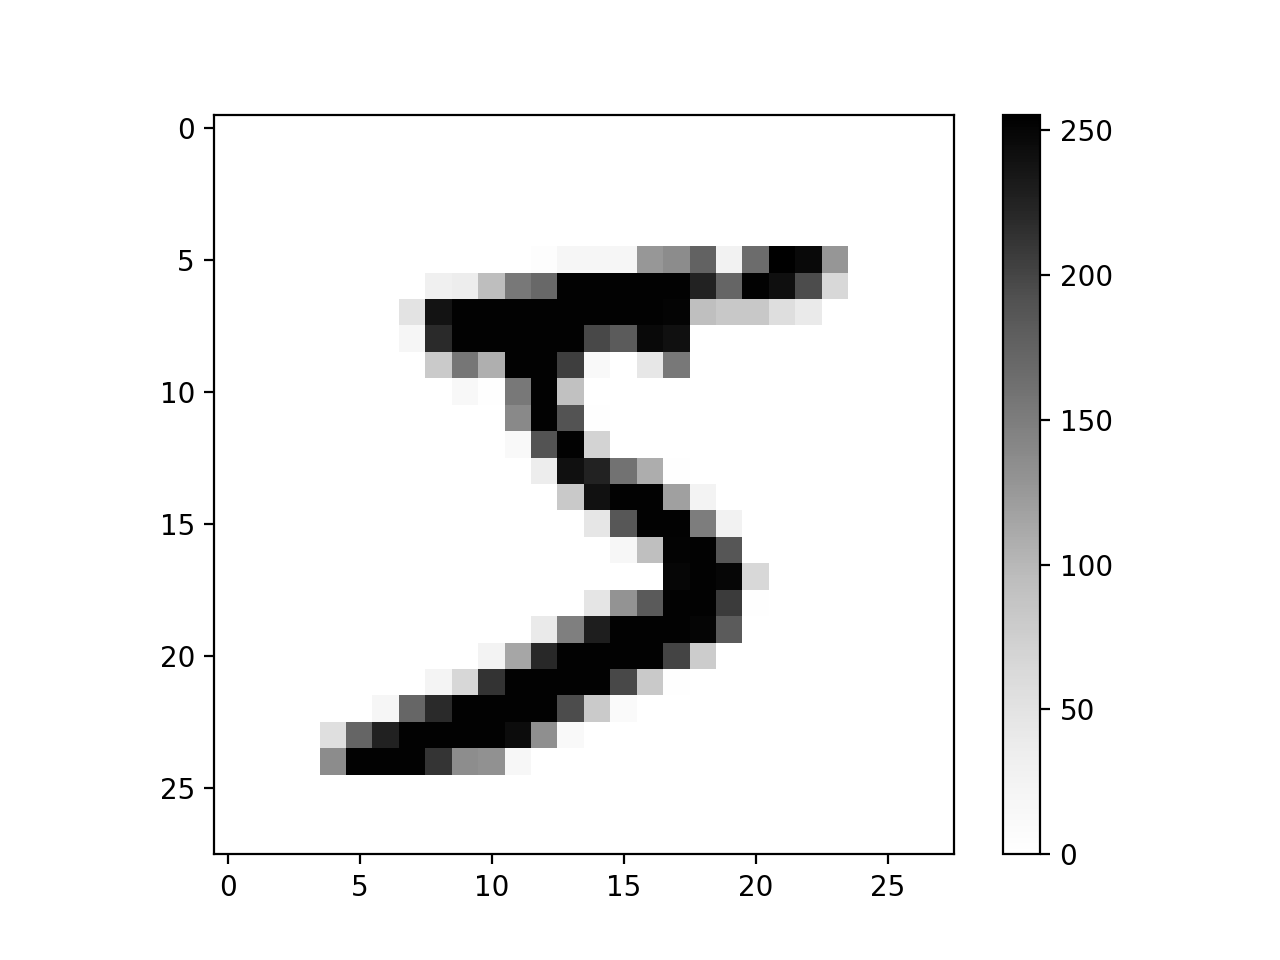

In [13]:
# show an example
print("Shape:", mnist_train_loader.dataset.train_data.shape)
x = mnist_train_loader.dataset.data[0]
print("type:", type(x.numpy()))
print("shape:", x.shape)
# print("sample:", x.numpy())

y = mnist_train_loader.dataset.targets[0]
print("Label:",y.numpy())
print("type:", type(y))

plt.imshow(x, cmap=plt.cm.get_cmap('Greys'))
plt.colorbar()
plt.show()

In [14]:
# loss functions for the classic net
lmbda_l2 = (4.0*0.1/len(mnist_train_loader.dataset))
print(lmbda_l2)

def classical_cross_ent_loss(model, output, target):
    cent_loss = F.cross_entropy(output, target.long())
    l2 = fgnh.l2_loss(model)
    return cent_loss + lmbda_l2*l2

6.66666666667e-06


In [15]:
# Initialize the classic network
hidden_l_nums = [64,64]
drop_p = 0.2

In [17]:
classic_model = fgnl.Feedforward_Classic_net(in_feats=28*28, out_feats=10, hidden_l_nums=hidden_l_nums, drop_p=drop_p).to(device)

In [13]:
# define model params to optimize
classic_optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, classic_model.parameters()),momentum=0.5)

In [14]:
epochs = 5

In [15]:
# train the network for N epochs
classic_train_res = fgnh.train(classic_model, mnist_train_loader, 
                             classical_cross_ent_loss, classic_optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=mnist_test_loader)

Epoch 0 Train set - Average loss: 0.5477, Accuracy: 49703/60000 (83%)
Test set - Average loss: 0.2964, Accuracy: 9138/10000 (91%)
Epoch 1 Train set - Average loss: 0.4030, Accuracy: 52716/60000 (88%)
Test set - Average loss: 0.2672, Accuracy: 9192/10000 (92%)
Epoch 2 Train set - Average loss: 0.3836, Accuracy: 52976/60000 (88%)
Test set - Average loss: 0.2526, Accuracy: 9266/10000 (93%)
Epoch 3 Train set - Average loss: 0.3684, Accuracy: 53420/60000 (89%)
Test set - Average loss: 0.2443, Accuracy: 9284/10000 (93%)
Epoch 4 Train set - Average loss: 0.3684, Accuracy: 53424/60000 (89%)
Test set - Average loss: 0.2369, Accuracy: 9312/10000 (93%)


In [16]:
# test the statibility of the model (these numbers should be same as final lines above)
classic_test_res_1 = fgnh.test(classic_model, mnist_train_loader, classical_cross_ent_loss,
                               pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.2369, Accuracy: 55784/60000 (93%)


In [17]:
### INTERLUDE

In [18]:
### Loss Functions for the FGN

# importances of the constraints
lmbda_l2 = (4.0*0.1/len(mnist_train_loader.dataset))
lmbda_sigs = 200.0*lmbda_l2
# sig_params = sum(p.numel() for n,p in fgn_model.named_parameters() if 'sigs' in n)
# lmbda_sigs = (1.0/sig_params)

# lmbda_l2 = 0.0
# lmbda_sigs = 0.0
print("lambda for l2 loss", lmbda_l2)
print("lambda for sigs^2 loss", lmbda_sigs)

def fgn_cross_ent_loss(model, output, target):
    
    # normal Cent loss
    cent_loss = F.cross_entropy(output, target.long())
    # normal l2 loss
    l2 = fgnh.l2_loss(model)
    #sigma loss
    sig_loss = fgnl.sigmas_loss(model)
    
    return cent_loss + lmbda_l2*l2 + lmbda_sigs*sig_loss


lambda for l2 loss 6.66666666667e-06
lambda for sigs^2 loss 2.66666666667e-05


In [19]:
# fgn specific params
ordinal = float(2)
print("ordinal:", ordinal)
noisy_centers = False
print("noisy centers:", noisy_centers)
random_eval = False
print("Random Eval", random_eval)

# Initialize the fgn network
fgn_model = fgnl.Feedforward_FGN_net(in_feats=28*28, out_feats=10, ordinal=ordinal, hidden_l_nums=hidden_l_nums, 
                                     drop_p=drop_p, noisy_centers=noisy_centers).to(device)

hidden layers [64, 64]
drop_p = 0.2
noisy centers: True


In [20]:
# define model params to optimize
fgn_optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, fgn_model.parameters()),momentum=0.5)

In [21]:
# train the network for N epochs
fgn_train_res = fgnh.train(fgn_model, mnist_train_loader, 
                             fgn_cross_ent_loss, fgn_optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=mnist_test_loader)

Epoch 0 Train set - Average loss: 1.2755, Accuracy: 45332/60000 (76%)
Test set - Average loss: 0.6169, Accuracy: 8593/10000 (86%)
Epoch 1 Train set - Average loss: 0.5069, Accuracy: 51991/60000 (87%)
Test set - Average loss: 0.4901, Accuracy: 8801/10000 (88%)
Epoch 2 Train set - Average loss: 0.4434, Accuracy: 53063/60000 (88%)
Test set - Average loss: 0.4145, Accuracy: 9049/10000 (90%)
Epoch 3 Train set - Average loss: 0.4017, Accuracy: 53745/60000 (90%)
Test set - Average loss: 0.3424, Accuracy: 9226/10000 (92%)
Epoch 4 Train set - Average loss: 0.3673, Accuracy: 54288/60000 (90%)
Test set - Average loss: 0.3179, Accuracy: 9207/10000 (92%)


In [22]:
# test the statibility of the model (these numbers should be same as final lines above)
fgn_test_res_1 = fgnh.test(fgn_model, mnist_train_loader, fgn_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

fgn_test_res_2 = fgnh.test(fgn_model, mnist_test_loader, fgn_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.3165, Accuracy: 55135/60000 (92%)
Test set - Average loss: 0.3179, Accuracy: 9206/10000 (92%)


In [ ]:
# switch to random eval
model.set_random_eval(True)
test_res = fgnh.test(model, mnist_train_loader,
                        cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

test_res = fgnh.test(model, mnist_test_loader,
                        cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

In [23]:
### INTERLUDE

In [24]:
# PART 3: Hybrid network with just the final layer as FGN, other hidden layers as Linear 

In [25]:
# loss function for hybrid
# same as fgn
hybrid_cross_ent_loss = fgn_cross_ent_loss

In [26]:
# Initialize the hybrid network
print("hidden layers:", hidden_l_nums)
print("drop prob:", drop_p)
noisy_centers = True
print("noisy centers:", noisy_centers)
hybrid_model = fgnl.Feedforward_Hybrid_Last_net(in_feats=28*28, out_feats=10, hidden_l_nums=hidden_l_nums,
                                     drop_p=drop_p, noisy_centers=noisy_centers).to(device)

hidden layers: [64, 64]
drop prob: 0.2
noisy centers: True


In [27]:
# define model params to optimize
hybrid_optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, hybrid_model.parameters()),momentum=0.5)

In [28]:
# train the network for N epochs
hybrid_train_res = fgnh.train(hybrid_model, mnist_train_loader, 
                             hybrid_cross_ent_loss, hybrid_optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=mnist_test_loader)

Epoch 0 Train set - Average loss: 1.2972, Accuracy: 47614/60000 (79%)
Test set - Average loss: 0.3676, Accuracy: 9039/10000 (90%)
Epoch 1 Train set - Average loss: 0.4657, Accuracy: 51918/60000 (87%)
Test set - Average loss: 0.3152, Accuracy: 9132/10000 (91%)
Epoch 2 Train set - Average loss: 0.4154, Accuracy: 52700/60000 (88%)
Test set - Average loss: 0.3221, Accuracy: 9064/10000 (91%)
Epoch 3 Train set - Average loss: 0.3851, Accuracy: 53080/60000 (88%)
Test set - Average loss: 0.3113, Accuracy: 9088/10000 (91%)
Epoch 4 Train set - Average loss: 0.3633, Accuracy: 53523/60000 (89%)
Test set - Average loss: 0.3322, Accuracy: 9084/10000 (91%)


In [29]:
# test the statibility of the model (these numbers should be same as final lines above)
hybrid_test_res = fgnh.test(hybrid_model, mnist_train_loader,
                        hybrid_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

hybrid_test_res = fgnh.test(hybrid_model, mnist_test_loader,
                        hybrid_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.3165, Accuracy: 54461/60000 (91%)
Test set - Average loss: 0.3322, Accuracy: 9084/10000 (91%)


<IPython.core.display.Javascript object>


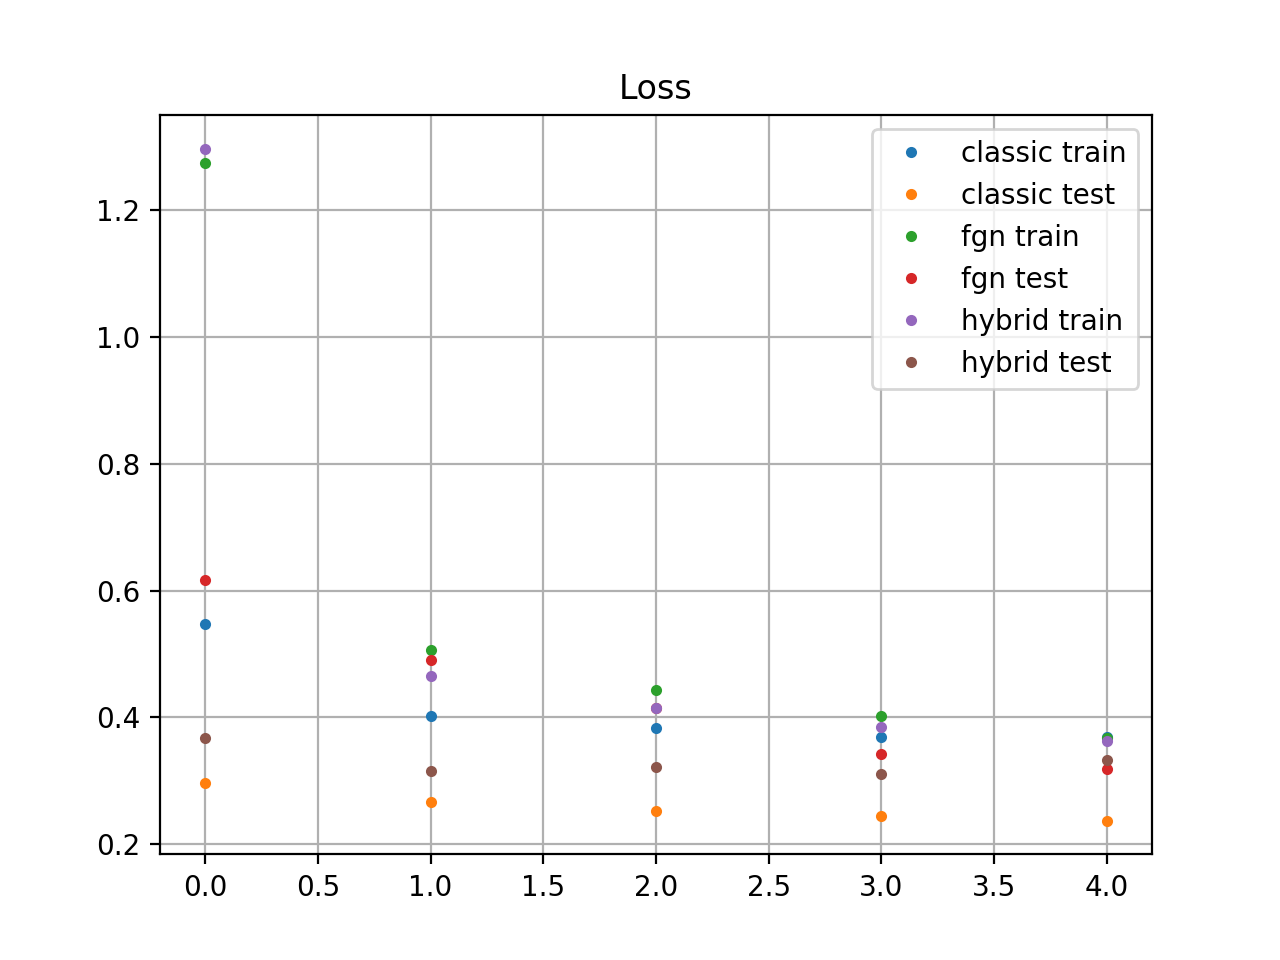

<IPython.core.display.Javascript object>


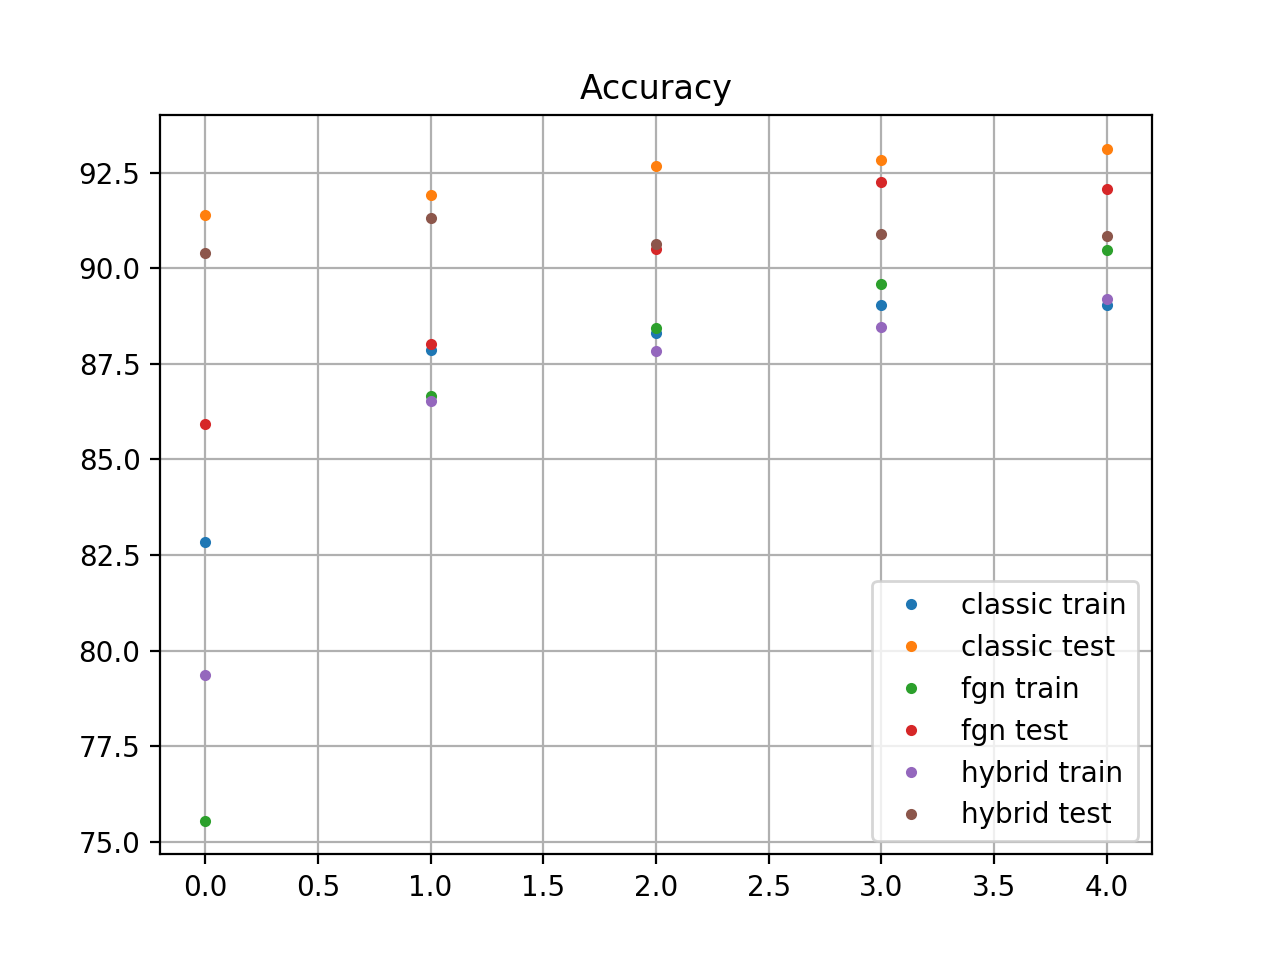

In [30]:
# acc and loss hist
plt.plot(classic_train_res['train_loss_hist'], marker='.', linestyle=' ', label='classic train')
plt.plot(classic_train_res['test_loss_hist'], marker='.', linestyle=' ', label='classic test')
plt.plot(fgn_train_res['train_loss_hist'], marker='.', linestyle=' ', label='fgn train')
plt.plot(fgn_train_res['test_loss_hist'], marker='.', linestyle=' ', label='fgn test')
plt.plot(hybrid_train_res['train_loss_hist'], marker='.', linestyle=' ', label='hybrid train')
plt.plot(hybrid_train_res['test_loss_hist'], marker='.', linestyle=' ', label='hybrid test')
plt.grid()
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(classic_train_res['train_acc_hist'], marker='.', linestyle=' ', label='classic train')
plt.plot(classic_train_res['test_acc_hist'], marker='.', linestyle=' ', label='classic test')
plt.plot(fgn_train_res['train_acc_hist'], marker='.', linestyle=' ', label='fgn train')
plt.plot(fgn_train_res['test_acc_hist'], marker='.', linestyle=' ', label='fgn test')
plt.plot(hybrid_train_res['train_acc_hist'], marker='.', linestyle=' ', label='hybrid train')
plt.plot(hybrid_train_res['test_acc_hist'], marker='.', linestyle=' ', label='hybrid test')
plt.grid()
plt.legend()
plt.title('Accuracy')
plt.show()

In [31]:
### plot some FGN param movement during training

hidden_layers.4.centers
plotting neurons: [28  9]


<IPython.core.display.Javascript object>


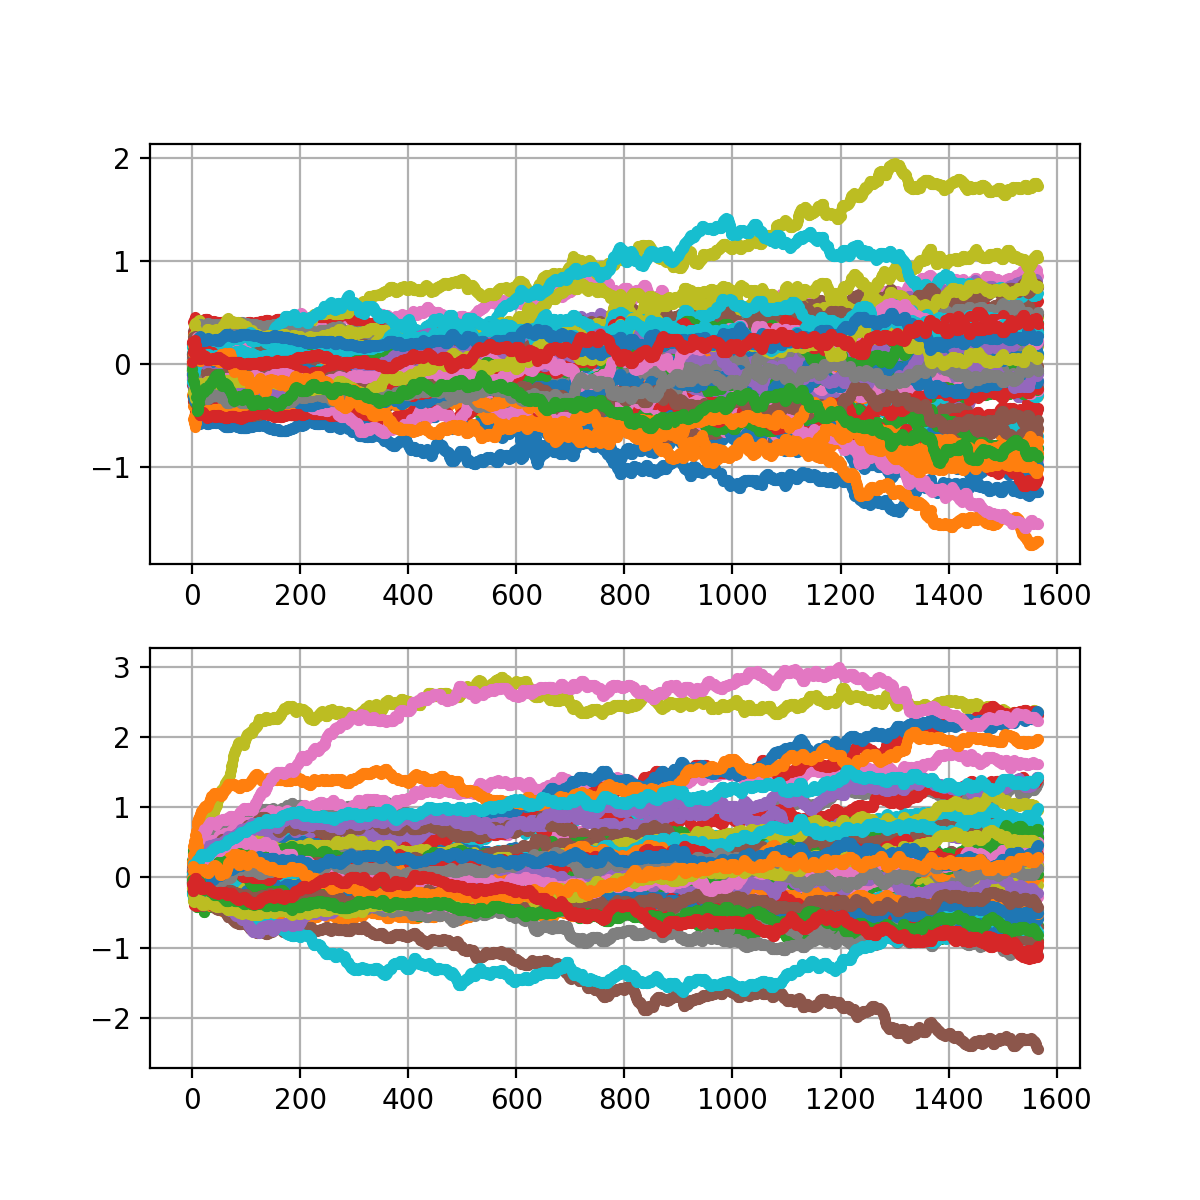

hidden_layers.1.centers
plotting neurons: [35 63]


<IPython.core.display.Javascript object>


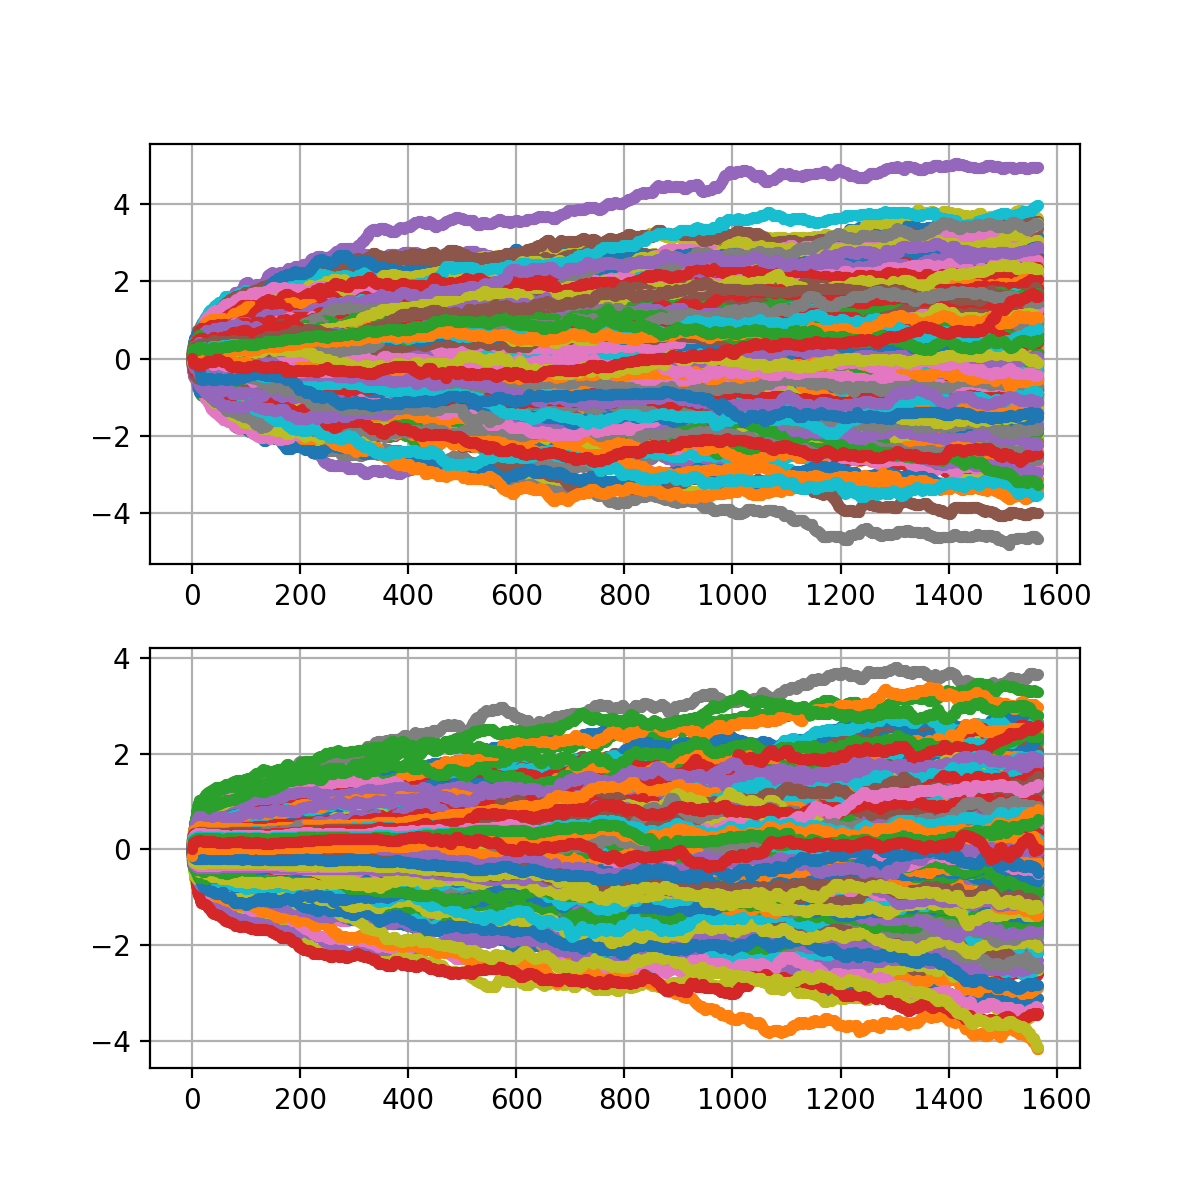

fl.centers
plotting neurons: [5 9]


<IPython.core.display.Javascript object>


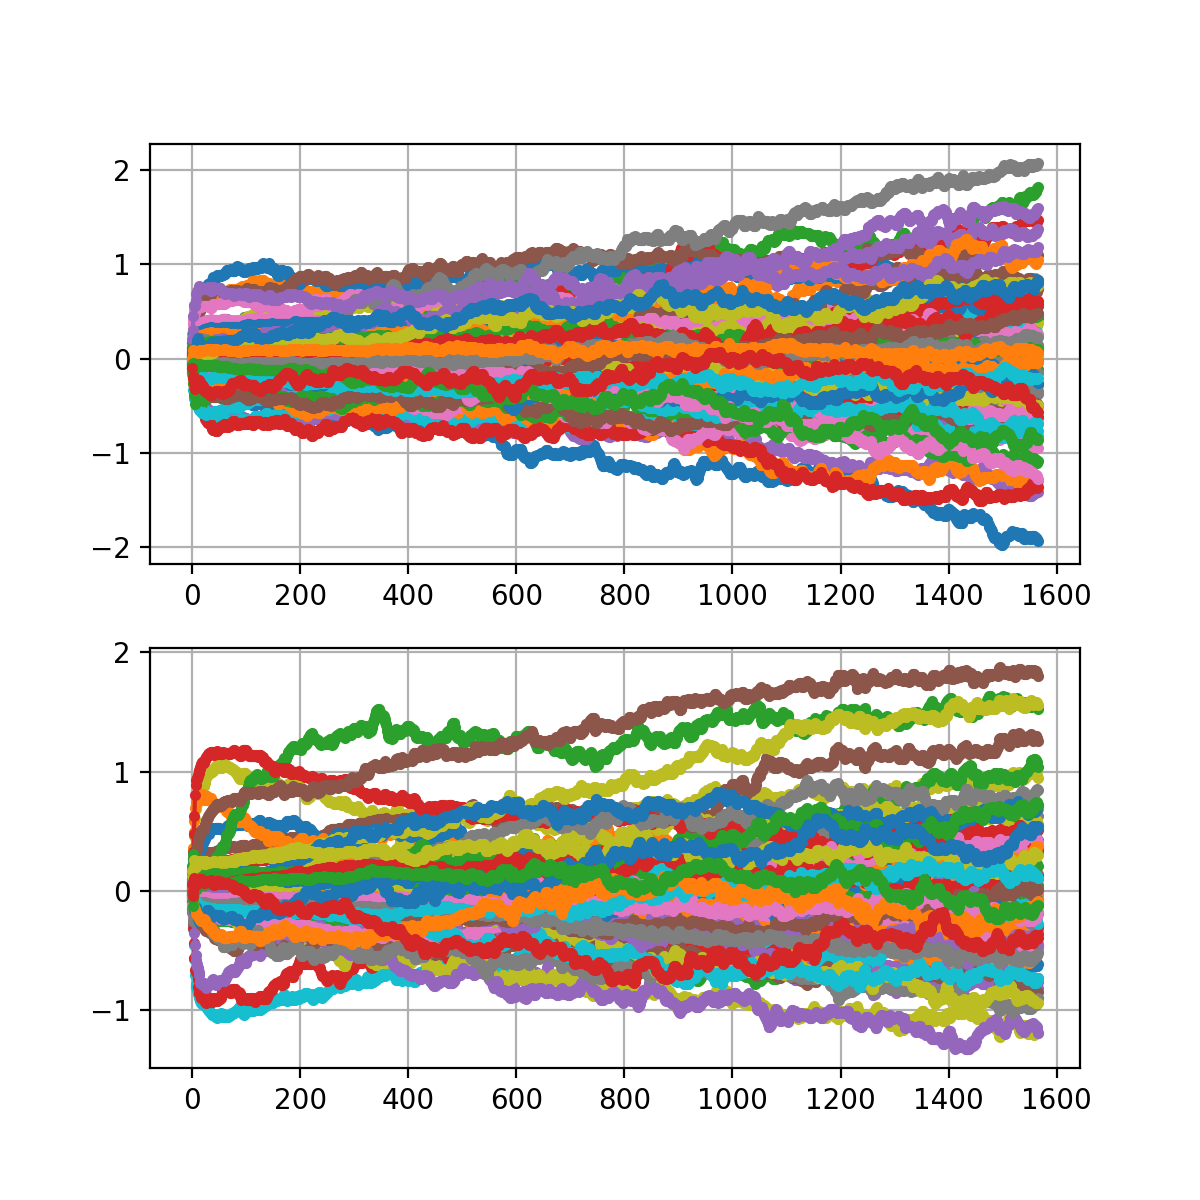

In [32]:
# plot centers history for only some hidden layer neuron
# for full FGN

for k in fgn_train_res['histories'].keys():
    if 'centers' in k:
        print(k)
        plt.figure(figsize=(6,6))
        # print(np.shape(fgn_fgn_train_res['histories'][k]))
        # choose 4random neurons in the layer to print
        neurons =  np.random.choice(range(np.shape(fgn_train_res['histories'][k])[1]),2, replace=False)
        print("plotting neurons:", neurons)
        # plt.figure(figsize=(2,2))

        for idx,n in enumerate(neurons):
            x = fgn_train_res['histories'][k][:,n,:]
            # print(np.shape(x))
            plt.subplot(2,1,idx+1)
            plt.plot(x, marker='.', linestyle='-')
            # plt.axis([-3,3, -3, 3])
            plt.grid()
        plt.show()
            
            

fl.sigmas


<IPython.core.display.Javascript object>


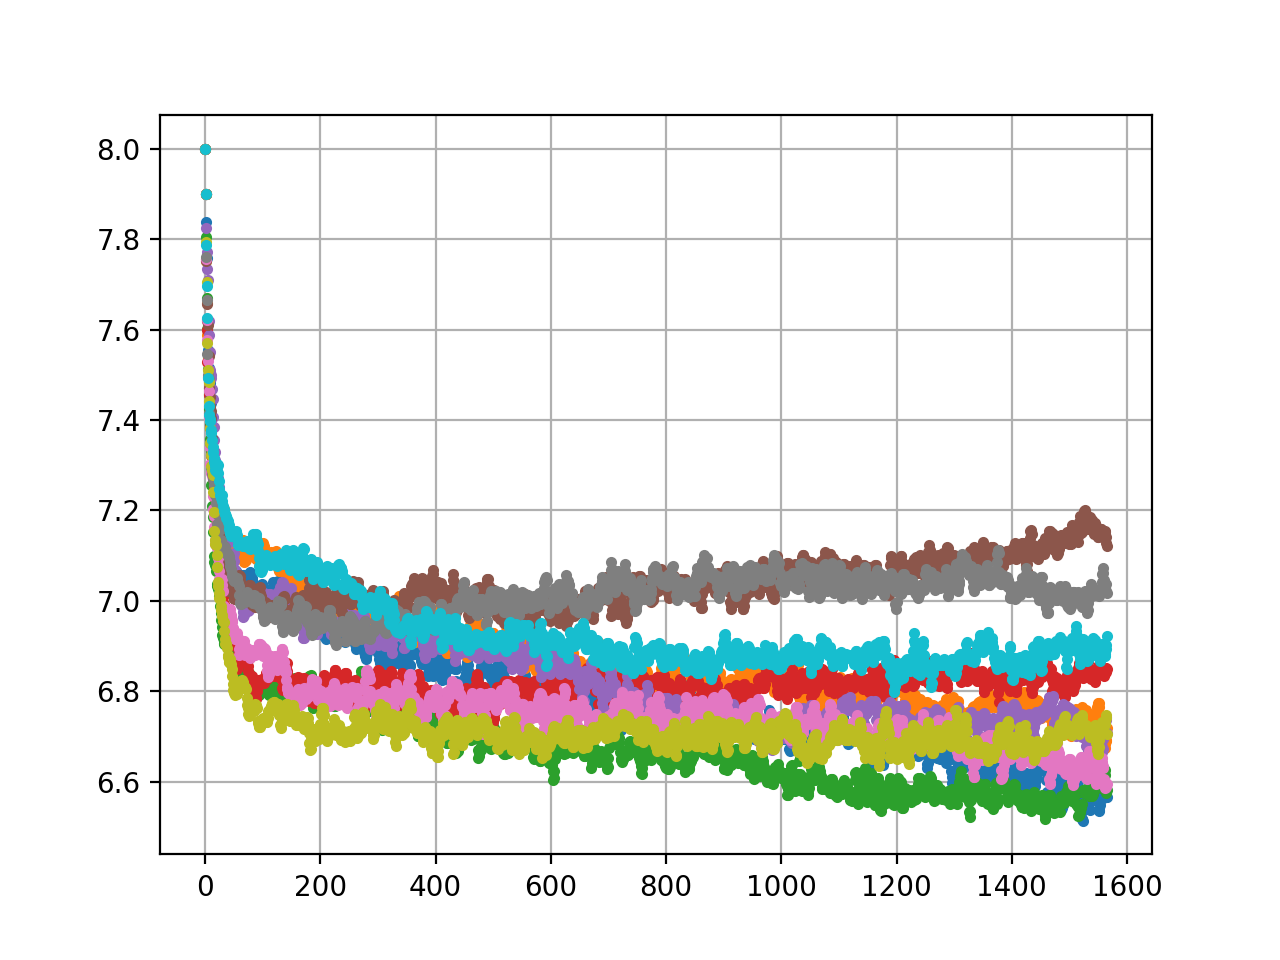

hidden_layers.4.sigmas


<IPython.core.display.Javascript object>


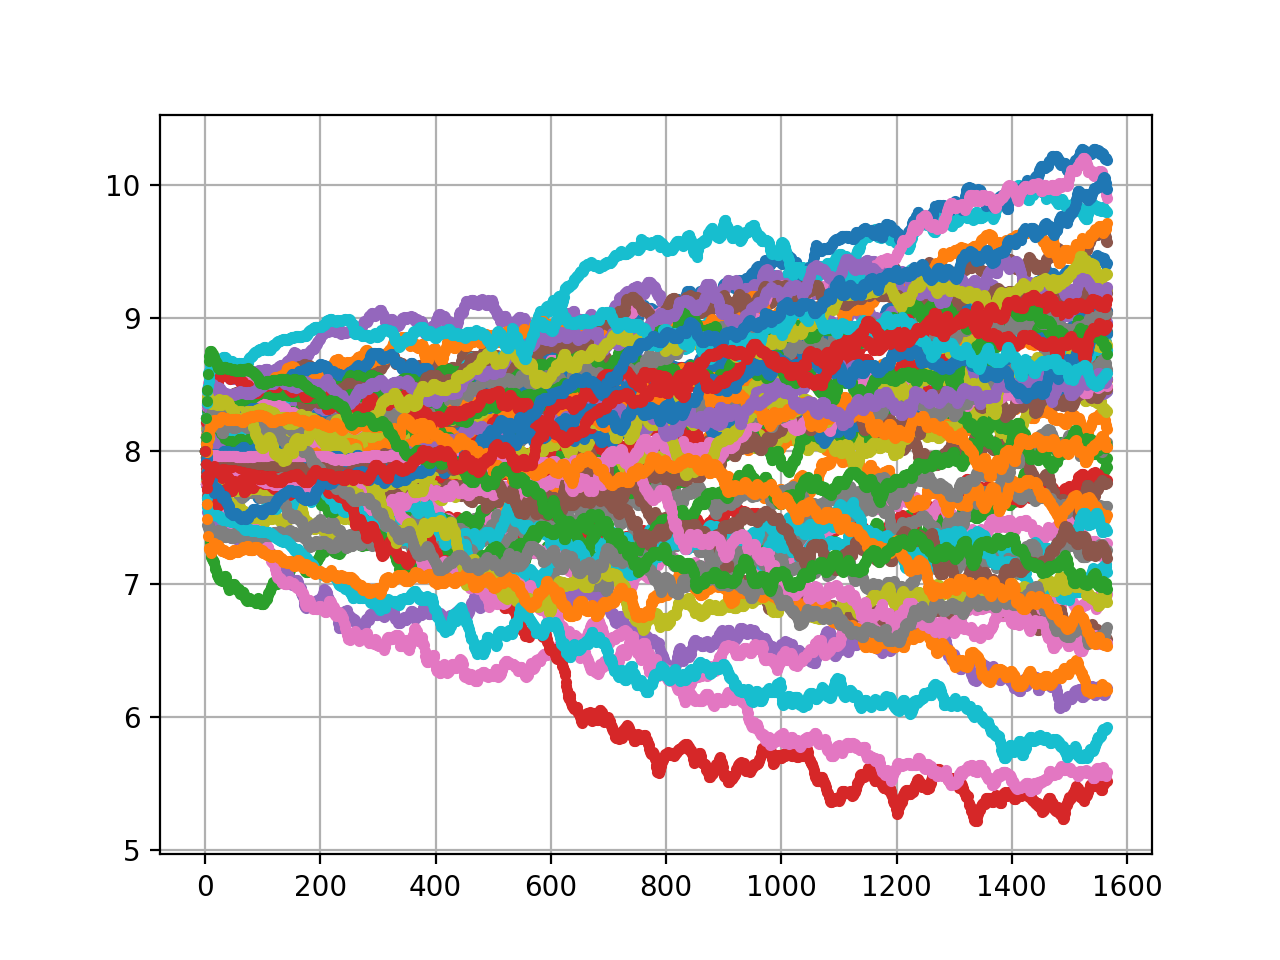

hidden_layers.1.sigmas


<IPython.core.display.Javascript object>


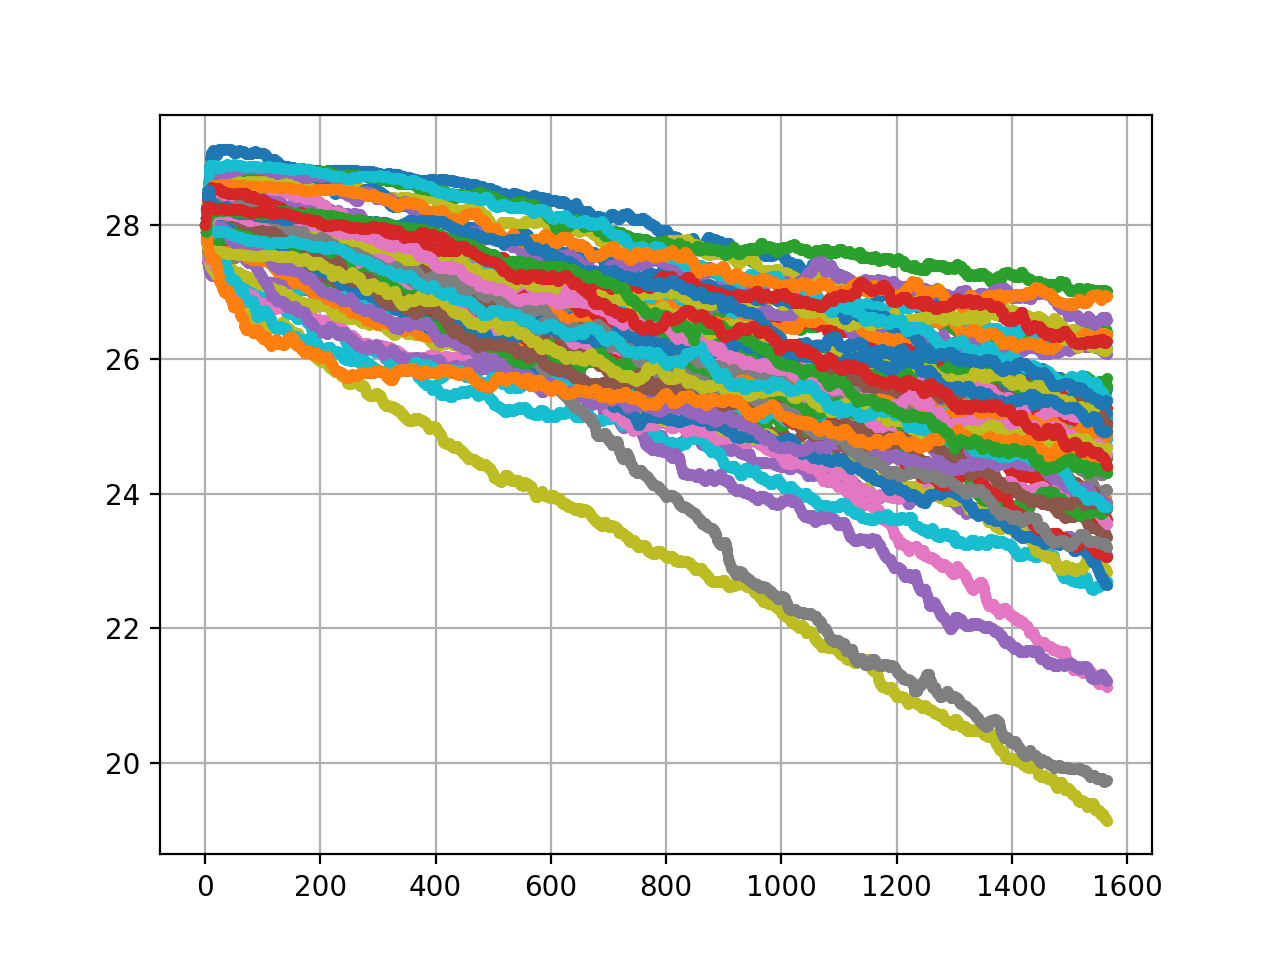

In [33]:
# check that sigma has shrunk
# plot sigma history
for k in fgn_train_res['histories'].keys():
    if 'sigmas' in k:
        print(k)
        for i in range(len(fgn_train_res['histories'][k][0])):
            plt.plot(fgn_train_res['histories'][k][:,i], marker='.', linestyle=' ')
        plt.grid()
        plt.show()

fl.centers
plotting neurons: [9 8]


<IPython.core.display.Javascript object>


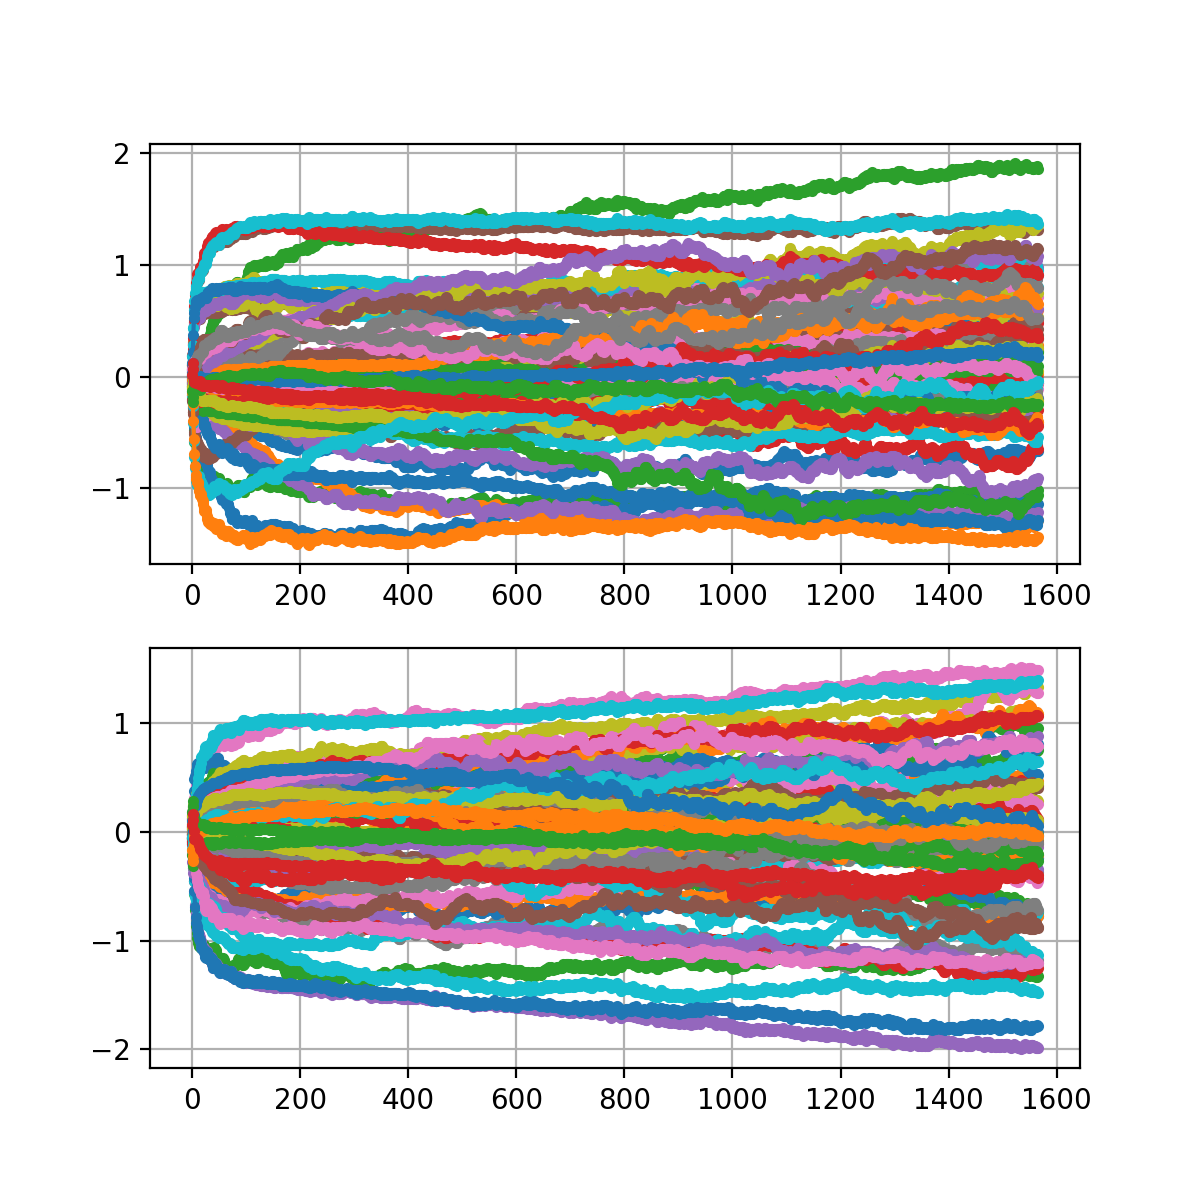

In [34]:
# plot centers history for only some hidden layer neuron
# for Hybrid FGN
for k in hybrid_train_res['histories'].keys():
    if 'centers' in k:
        print(k)
        plt.figure(figsize=(6,6))
        # print(np.shape(fgn_fgn_train_res['histories'][k]))
        # choose 4random neurons in the layer to print
        neurons =  np.random.choice(range(np.shape(hybrid_train_res['histories'][k])[1]),2, replace=False)
        print("plotting neurons:", neurons)
        # plt.figure(figsize=(2,2))

        for idx,n in enumerate(neurons):
            x = hybrid_train_res['histories'][k][:,n,:]
            # print(np.shape(x))
            plt.subplot(2,1,idx+1)
            plt.plot(x, marker='.', linestyle='-')
            # plt.axis([-3,3, -3, 3])
            plt.grid()
        plt.show()

fl.sigmas


<IPython.core.display.Javascript object>


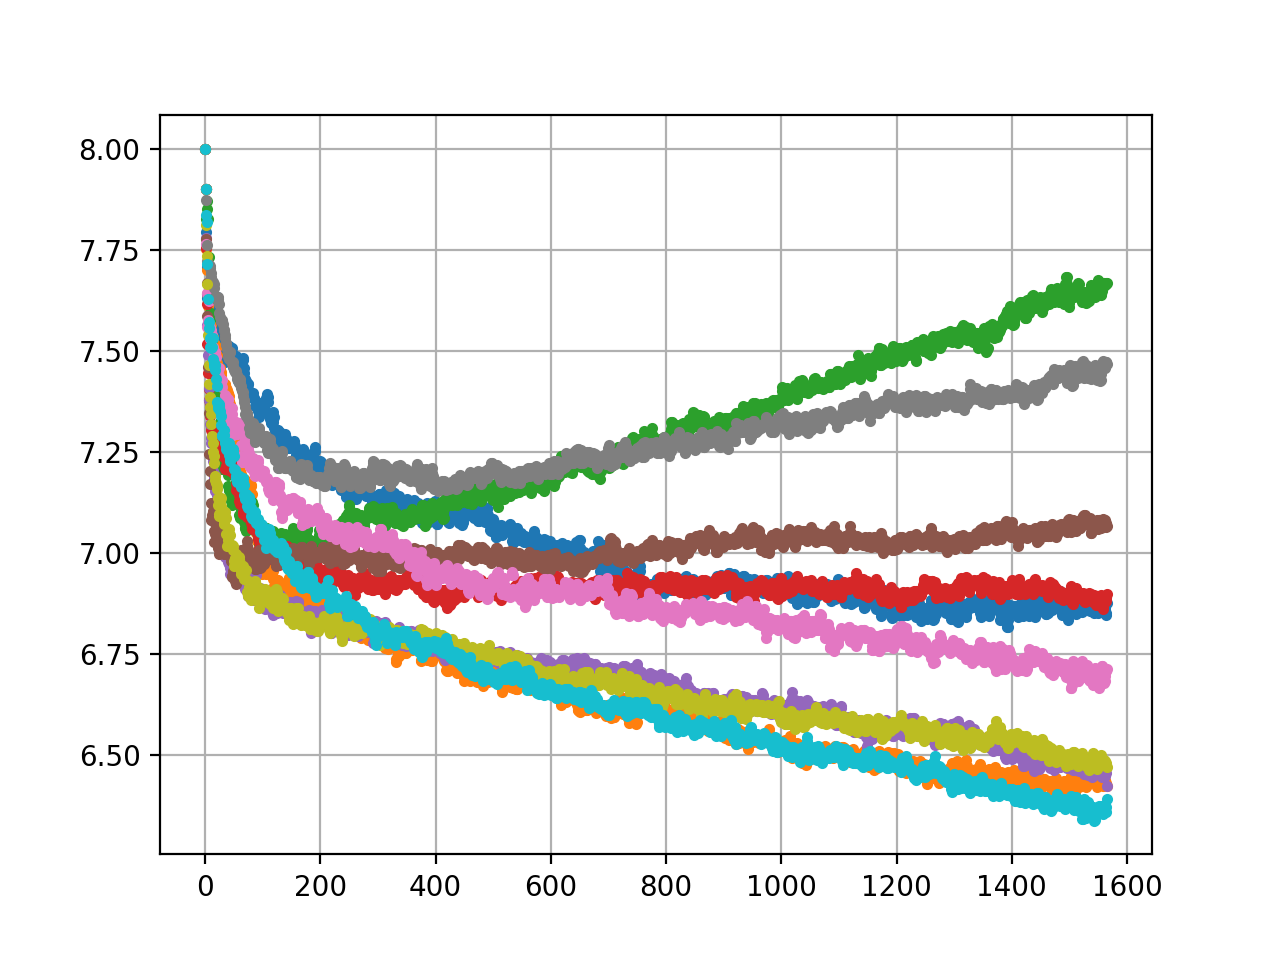

In [35]:
# check that sigma has shrunk
# plot sigma history
for k in hybrid_train_res['histories'].keys():
    if 'sigmas' in k:
        print(k)
        for i in range(len(hybrid_train_res['histories'][k][0])):
            plt.plot(hybrid_train_res['histories'][k][:,i], marker='.', linestyle=' ')
        plt.grid()
        plt.show()

In [36]:
# save the models as dev models for future use

In [37]:
# classic_model_name = "sample_classic_model_long"
# save_path = "../Experiments/sample_models/"
# print("Saving trained model {} in {}".format(classic_model_name, save_path))

# # save model entirely
# torch.save(classic_model, save_path+classic_model_name+"_full.pth")

# # save model weights
# torch.save(classic_model.state_dict(), save_path+classic_model_name+"_state_dict.pth")

# # save training performance
# with open(save_path+classic_model_name+"_history.txt", "w") as text_file:
#     text_file.write("Train Losses \n{}\n".format(str(classic_train_res['train_loss_hist'])))
#     text_file.write("Train Acc \n{}\n".format(str(classic_train_res['train_acc_hist'])))
#     text_file.write("Test Losses \n{}\n".format(str(classic_train_res['test_loss_hist'])))
#     text_file.write("Test Acc \n{}\n".format(str(classic_train_res['test_acc_hist'])))

# # save parameters
# with open(save_path+classic_model_name+"_parameters.txt", "w") as text_file:
#     text_file.write("hidden_l_nums {}\n".format(str(hidden_l_nums)))
#     text_file.write("drop_p {}\n".format(str(drop_p)))
#     text_file.write("batch_size {}\n".format(str(batch_size)))

In [40]:
# fgn_model_name = "sample_fgn_model_noisy_eval"
# save_path = "../Experiments/sample_models/"
# print("Saving trained model {} in {}".format(fgn_model_name, save_path))

# # save model entirely
# torch.save(fgn_model, save_path+fgn_model_name+"_full.pth")

# # save model weights
# torch.save(fgn_model.state_dict(), save_path+fgn_model_name+"_state_dict.pth")

# # save training performance
# with open(save_path+fgn_model_name+"_history.txt", "w") as text_file:
#     text_file.write("Train Losses \n{}\n".format(str(fgn_train_res['train_loss_hist'])))
#     text_file.write("Train Acc \n{}\n".format(str(fgn_train_res['train_acc_hist'])))
#     text_file.write("Test Losses \n{}\n".format(str(fgn_train_res['test_loss_hist'])))
#     text_file.write("Test Acc \n{}\n".format(str(fgn_train_res['test_acc_hist'])))

# # save parameters
# with open(save_path+fgn_model_name+"_parameters.txt", "w") as text_file:
#     text_file.write("hidden_l_nums {}\n".format(str(hidden_l_nums)))
#     text_file.write("drop_p {}\n".format(str(drop_p)))
#     text_file.write("noisy_centers {}\n".format(str(noisy_centers)))
#     text_file.write("batch_size {}\n".format(str(batch_size)))

Saving trained model sample_fgn_model_noisy_eval in ../Experiments/sample_models/


In [39]:
# hybrid_model_name = "sample_hybrid_model_long"
# save_path = "../Experiments/sample_models/"
# print("Saving trained model {} in {}".format(hybrid_model_name, save_path))

# # save model entirely
# torch.save(hybrid_model, save_path+hybrid_model_name+"_full.pth")

# # save model weights
# torch.save(hybrid_model.state_dict(), save_path+hybrid_model_name+"_state_dict.pth")

# # save training performance
# with open(save_path+hybrid_model_name+"_history.txt", "w") as text_file:
#     text_file.write("Train Losses \n{}\n".format(str(hybrid_train_res['train_loss_hist'])))
#     text_file.write("Train Acc \n{}\n".format(str(hybrid_train_res['train_acc_hist'])))
#     text_file.write("Test Losses \n{}\n".format(str(hybrid_train_res['test_loss_hist'])))
#     text_file.write("Test Acc \n{}\n".format(str(hybrid_train_res['test_acc_hist'])))

# # save parameters
# with open(save_path+hybrid_model_name+"_parameters.txt", "w") as text_file:
#     text_file.write("hidden_l_nums {}\n".format(str(hidden_l_nums)))
#     text_file.write("drop_p {}\n".format(str(drop_p)))
#     text_file.write("noisy_centers {}\n".format(str(noisy_centers)))
#     text_file.write("batch_size {}\n".format(str(batch_size)))